# Telco Customer Churn Analysis
https://www.kaggle.com/blastchar/telco-customer-churn

### Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." 

### Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn

- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

- Demographic info about customers – gender, age range, and if they have partners and dependents

### Methodology

We will use aspects of survival analysis to survey possible models that best represent customer churn. One might be tempted to construct a model using logistic regression, which is adequate; however, I believe it is more beneficial for researchers to use what survival analysis excels in interpreting - time-to-event data. 

In [135]:
import pandas as pd 
import numpy as np
import lifelines as life

pd.options.mode.chained_assignment = None #silence copy warnings

In [136]:
data = pd.read_csv("E:/Downloads/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(list(data))
data.head()

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preparation

It is apparent most variables listed in the summary above need to be binarized or regrouped into a dichotomous scheme. For example, for variables with a "Yes"-"No" value can be relabeled to 0 or 1; whereas, a more sophisticated variable, such as PaymentMethod, can be dichotomized if we bin the support into "manual" or "automatic" payment methods (i.e. 0 or 1). Other variables were labeled using a similar reasoning. 

In [137]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cont_filter = ['customerID','tenure','MonthlyCharges','TotalCharges'] #filter out variables that do not need encoding

filtered_columns = [x for x in list(data) if x not in cont_filter]

#At this step we find all variables that have more than a dichotomous realization, i.e. more than two classes!
mult_class = data[filtered_columns].apply(set).apply(list).apply(len).__gt__(2).apply(int) #sloppy chain 
mult_class = mult_class[mult_class==1].index.values #get row names, these are actually the column names we want

dummies = pd.get_dummies(data[mult_class]) #dummify

#We will drop redundant variables - for example, the online security variable has an 'onlinesecurity_no internet service'
#dummy variable which is not needed do to the InternetService_No dummy variable. 
re_filter = ['internet service'] #redundant
re_columns = [x for x in list(dummies) for y in re_filter if y not in x]  

dummies_reduced = dummies[re_columns]

reduced_df = pd.DataFrame()

paymentmethod_automatic_manual =  dummies_reduced['PaymentMethod_Bank transfer (automatic)'] + dummies_reduced['PaymentMethod_Credit card (automatic)']
contract_month_year = dummies_reduced['Contract_One year'] + dummies_reduced['Contract_Two year']
internet_service = dummies_reduced['InternetService_DSL'] + dummies_reduced['InternetService_Fiber optic']

reduced_df['PaymentMethod_automatic_manual'] = paymentmethod_automatic_manual
reduced_df['Contract_month_year'] = contract_month_year
reduced_df['InternetService'] = internet_service

#reduced_df['CustomerId'] = data['customerID']
reduced_df['Tenure'] = data['tenure']
reduced_df['MonthlyCharges'] = data['MonthlyCharges']
reduced_df['TotalCharges'] = data['TotalCharges']

gender = list(map(le.fit_transform,[data['gender']])).pop()
dependents = list(map(le.fit_transform,[data['Dependents']])).pop()
phone_service = list(map(le.fit_transform,[data['PhoneService']])).pop()
churn = list(map(le.fit_transform,[data['Churn']])).pop()
partner = list(map(le.fit_transform,[data['Partner']])).pop()

reduced_df['Gender'] = gender
reduced_df['Dependents'] = dependents
reduced_df['PhoneService'] = phone_service                                          
reduced_df['Churn'] = churn
reduced_df['Partner'] = partner


reduced_df['SeniorCitizen'] = data['SeniorCitizen']
reduced_df['MultipleLines'] = dummies_reduced['MultipleLines_Yes']
reduced_df['StreamingMovies'] = dummies_reduced['StreamingMovies_Yes']
reduced_df['OnlineBackup'] = dummies_reduced['OnlineBackup_Yes']
reduced_df['OnlineSecurity'] = dummies_reduced['OnlineSecurity_Yes']
reduced_df['DeviceProtection'] = dummies_reduced['DeviceProtection_Yes']
reduced_df['TechSupport'] = dummies_reduced['TechSupport_Yes']

data = reduced_df

In [111]:
#problem cases - these customers are brand new, so we'll set the monthlycharges = 0.00 since they have yet to recieve a bill.
data['TotalCharges'].replace(to_replace=' ',value=0.00,inplace=True)

In [112]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

## Kaplan-Meier Curves

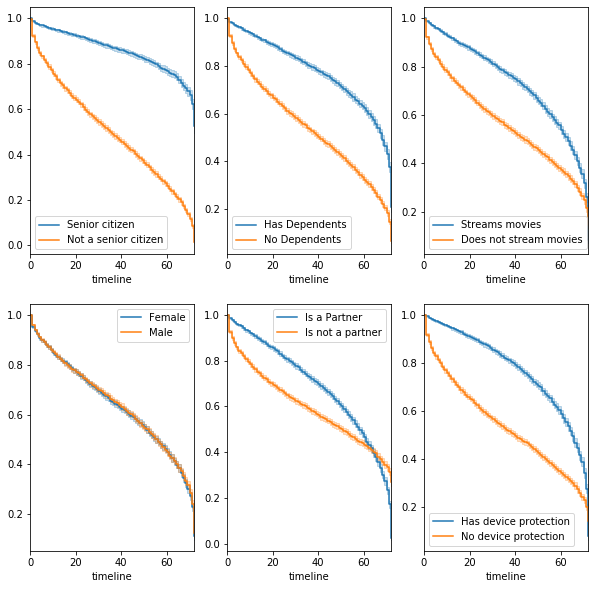

In [113]:
from lifelines import KaplanMeierFitter
import  matplotlib.pyplot as plt 
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,10))

cohort = ['SeniorCitizen','Dependents','StreamingMovies','Gender','Partner','DeviceProtection']

label = { 'SeniorCitizen' : ['Senior citizen' , 'Not a senior citizen'],
          'Dependents' : ['Has Dependents', 'No Dependents'],
          'StreamingMovies' : ['Streams movies', 'Does not stream movies'],
          'Gender' : ['Female','Male'],
          'Partner' : ['Is a Partner','Is not a partner'],
          'DeviceProtection' : ['Has device protection','No device protection']
        }

for k in range(len(cohort)):
    plt.subplot(2,3,k+1)
    group = cohort[k]
    kmf.fit(data['Tenure'],data[group])
    kmf.plot()
    kmf.fit(data['Tenure'],1-data[group])
    kmf.plot()
    plt.legend(label[group])
plt.show()

#### Kaplan-Meier Curves and the Subtleness of their Interpretation + More

Based on the Kaplan-Meier estimate representing the senior citizen vs. non-senior citizen population, we conclude that senior citizen retention is higher than non-senior citizens. There is also a subtley one needs to recognize, where the dropoff occurs in the observed estimates. The senior citizen estimate has a defined dropoff at the end of the curve which suggests the longest subscribed senior citizens churn.

There is still more to be said, moving our attention to the parter Kaplan-Meier curve brings us to another problem that will *likely* affect us during the model development stage - violation of the Cox Proportional-Hazard assumption. Briefly, the Cox Proportional-Hazard assumption states that the hazard rate must remain the same for all individuals. The violation is clearly seen towards the tail of the estimates by the interesecting curves.     

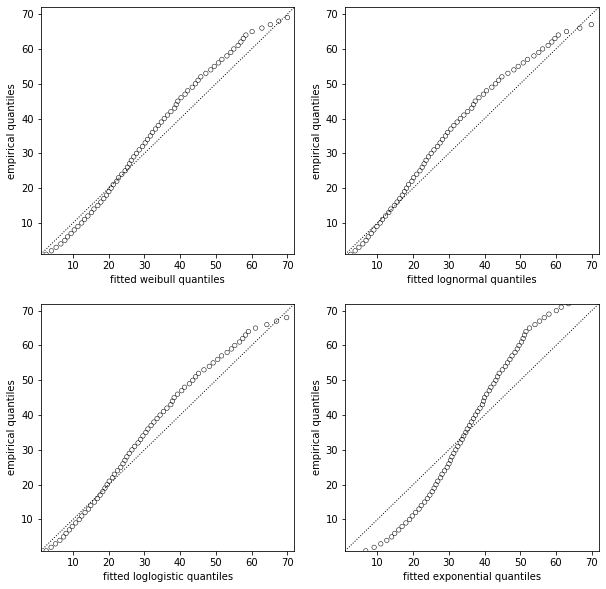

In [114]:
from lifelines import WeibullFitter,LogNormalFitter,LogLogisticFitter,ExponentialFitter
from lifelines.plotting import qq_plot

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.reshape(4,)
epsilon = 1e-5

for i, model in enumerate([WeibullFitter(),LogNormalFitter(),LogLogisticFitter(),ExponentialFitter()]):
    model.fit(data['Tenure'] + epsilon,data['Churn'])
    qq_plot(model,ax=axes[i])

## Cox Proportional-Hazard Model

$$\lambda(t|X_i) = \lambda_0 exp(\beta_1X_{i1} +  \ldots + \beta_{j}X_{ij})$$

##### Proportional hazard assumption

- All individuals have the same hazard function 

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'Contract_month_year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_month_year', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'InternetService' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['InternetService', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'MonthlyCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'MonthlyCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MonthlyCharges' using pd.cut, and then specify it in
`strata=['MonthlyCharges', ...]` in the 

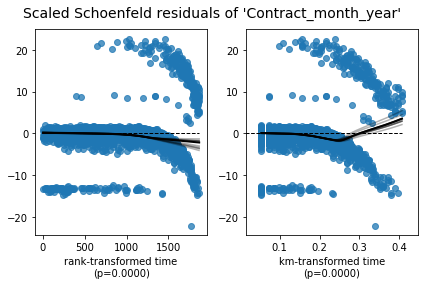

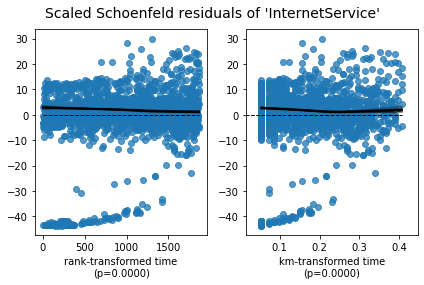

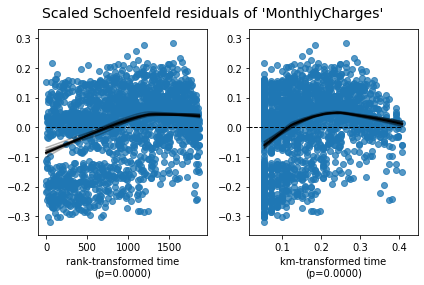

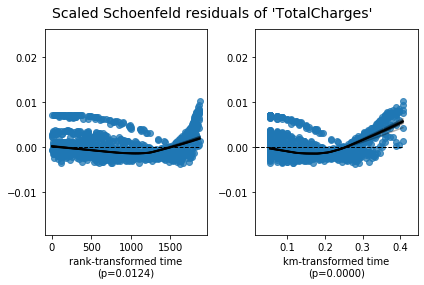

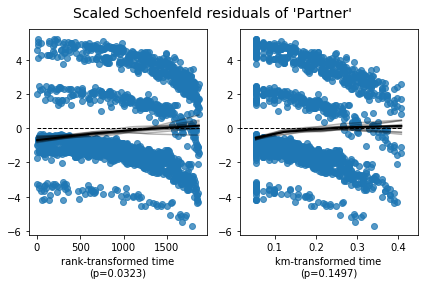

In [115]:
from lifelines import CoxPHFitter
cph_0 = CoxPHFitter()
cph_0.fit(data,duration_col='Tenure',event_col='Churn')
cph_0.print_summary()
cph_0.check_assumptions(data,p_value_threshold=0.05,show_plots=True) #Check proportional hazards assumption

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'PaymentMethod_automatic_manual' failed the non-proportional test: p-value is 0.0015.

   Advice: with so few unique values (only 2), you can include
`strata=['PaymentMethod_automatic_manual', ...]` in the call in `.fit`. See documentation in link
[E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



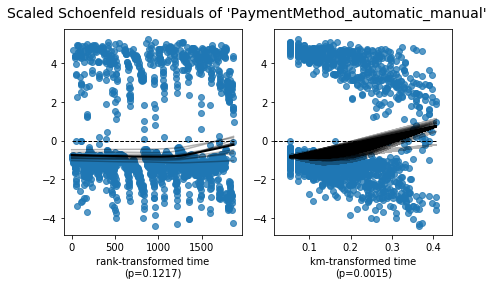

In [116]:
from lifelines import CoxPHFitter

data = data.drop(columns=['TotalCharges'])
monthly_charges_strata = pd.cut(data['MonthlyCharges'],np.arange(0,200,4),include_lowest=True)
data['MonthlyChargesStrata'] = monthly_charges_strata
data = data.drop(columns=['MonthlyCharges'])
strata = ['MonthlyChargesStrata','InternetService','Contract_month_year']

cph_1 = CoxPHFitter()
cph_1.fit(data,duration_col='Tenure',event_col='Churn',strata=strata)
cph_1.print_summary()
cph_1.check_assumptions(data,p_value_threshold=0.01,show_plots=True) #Check proportional hazards assumption

In [117]:
strata = ['MonthlyChargesStrata','InternetService','Contract_month_year','PaymentMethod_automatic_manual']

cph_2 = CoxPHFitter()
cph_2.fit(data,duration_col='Tenure',event_col='Churn',strata=strata)
cph_2.print_summary()
cph_2.check_assumptions(data,p_value_threshold=0.01,show_plots=True) #Check proportional hazards assumption

Proportional hazard assumption looks okay.


#### Why did you bin and stratify some of the predictors?

It is often the case we need to multiply a predictor with time, find a new functional form, or bin-stratify. These techniques are used to satisfy the proportional hazards assumption if it fails. Luckily, it just so happens the assumption is satisfied if the MonthlyCharges variable is bin-stratified while several others are stratistfied.  

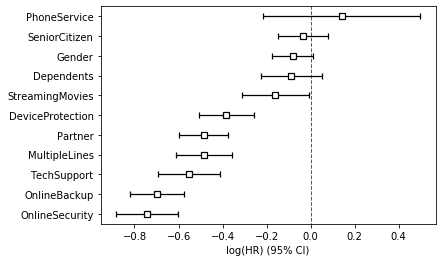

In [130]:
cph_2.plot()

### Interpreting Coefficients

We can interpret coefficients in a similar manner as seen in Linear Regression; however, there is a noticeable difference in how these coefficients are interpreted once they are exponentiated. As a general framework: If the hazard ratio, i.e. $ \exp(\beta_i) $, is near 1 then the predictor does not affect survival. If the hazard ratio is more than 1, the associated predictor decreases survival. Finally, if the hazard ratio is less than 1, the predictor improves survival. 

Under this general framework it is apparent the predictors Gender, SeniorCitizen, and Dependents do not affect churn. Moreover, predictors Partner, StreamingMovies, DeviceProtection, MultipleLines, TechSupport, OnlineBackup, and OnlineSecurity reduces churn; and the PhoneService predictor increases churn. 

### Tid-bits

There must be a note of caution when designing a model because it may be the case a researcher *must* have certain control variable in-place. For the sake of our study, we are going by means of model adequacy and stay firm on what the model defies.   


### Other Thoughts

Based on the present analysis, it is apparent that the level of phone service a customer recieves is highly indicative of whether or not they will keep their service. Also note the amount of variation seen in the box-and-whisker plot above for the phone service predictor. It is clear that customers are recieving a wide range of phone service that varies customer to customer - it is not consistant at all.   